# Cell-Cell Communication

Author: Francesca Drummer

In this notebook we will cover different methods to revocer cell-cell communication (CCC) in spatial transcriptomics. 

1. non-spatial CCC testing with spatial DE genes or post-processing filter (e.i. spatial distance) using CellPhoneDB
2. spatially weighted analysis using SpatialDM
3. spatially constrained analysis using COMMOT?

To reduce the environment dependencies we will use the LIANA+ implementation of the methods. 
Please notice that the original tools might offer more functionalities. 
For that reason we will always link to the original publication and GitHub repository.

In [47]:
import squidpy as sq
import scanpy as sc

from pathlib import Path
import numpy as np

from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

## 0. Download data

In [2]:
PATH = "/home/icb/francesca.drummer/1-Projects/"

In [3]:
# load adata
adata = sc.read_h5ad(Path(PATH, 'xenium_mouse_ad_annotated.h5ad'))
adata

AnnData object with n_obs × n_vars = 350209 × 347
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [4]:
print(adata.X[:10,:10])

  (1, 0)	1.0
  (2, 8)	1.0
  (3, 8)	1.0
  (4, 2)	1.0
  (4, 3)	3.0
  (8, 4)	1.0
  (8, 8)	1.0
  (9, 1)	1.0
  (9, 3)	2.0
  (9, 8)	1.0


## 0. Introduction to LIANA+

[LIANA+](https://liana-py.readthedocs.io/en/latest/notebooks/basic_usage.html) is a toolbox in Python for various dissociated, multimodal and spatially informed cell-cell communication tools [Dimitrov et al., 2024]. 

First we install the package and observe which methods are implemented in LIANA+. 
Each method relies on different assumptions and returns a different ligand-receptor score. 
Usually, one score for the strength of the interaction (`magnitude`) and a score reflecting the `specifivity` of a interaction to a pair of cell identities. 

In [5]:
import liana as li

li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


Most CCC tools identify LR interaction. For this they rely on a extracting LR pairs from databases. There are diverse databases but LIANA+ has a consensus database that uses LR that are overlapping across databases. 

First, we need to ensure that there are LR-pairs present in the data to be detected for communication.

In [53]:
print(li.resource.show_resources())
resource_name = "mouseconsensus"  # Replace with the desired resource name if needed
lr_pairs = li.resource.select_resource(resource_name)
lr_pairs

['baccin2019', 'cellcall', 'cellchatdb', 'cellinker', 'cellphonedb', 'celltalkdb', 'connectomedb2020', 'consensus', 'embrace', 'guide2pharma', 'hpmr', 'icellnet', 'italk', 'kirouac2010', 'lrdb', 'mouseconsensus', 'ramilowski2015']


,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3
...,...,...
35355,Serpina1a,Lrp1
35356,Serpina1b,Lrp1
35357,Serpina1c,Lrp1
35358,Serpina1d,Lrp1


In [39]:
genes_in_dataset = set(adata.var_names)  # Replace `adata.var_names` with your dataset's gene names if different

# Filter the ligand-receptor pairs for those present in your dataset
filtered_lr_pairs = lr_pairs[
    lr_pairs['ligand'].isin(genes_in_dataset) & lr_pairs['receptor'].isin(genes_in_dataset)
]

# Count the number of ligand-receptor pairs present in your dataset
num_lr_pairs = len(filtered_lr_pairs)

# Display the count
print(f"Number of ligand-receptor pairs present in the dataset: {num_lr_pairs}")

Number of ligand-receptor pairs present in the dataset: 16


In the following chapter, we will work with the CellPhoneDB method from LIANA+.

## 1. CellPhoneDB: non-spatial CCC

We will cover two possible appraoches to integrate spatial information into non-spatially aware CCC tools, as shown by `li.mt.show_methods()`. 

1. Select spatially variable genes as input. 
2. Input all genes into the 

### Spatially-variable gene selection

We use Moran's I score as a measure of spatial autocorrelation to identify spatially variable genes. 

For more information see: [Chapter 29: Spatially variable genes](https://www.sc-best-practices.org/spatial/spatially_variable_genes.html) from single-cell best practices.

In [66]:
sub_adata = adata[(adata.obs['time'] == '5_7') & (adata.obs['condition'] == 'TgCRND8')]
sub_adata

View of AnnData object with n_obs × n_vars = 58681 × 347
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [7]:
# sc.pp.normalize_total(sub_adata)
# sc.pp.log1p(sub_adata)

In [8]:
print(sub_adata.X[:5,:5])

  (0, 2)	4.0
  (1, 0)	3.0
  (1, 2)	3.0
  (2, 2)	2.0
  (4, 0)	1.0
  (4, 2)	2.0


In [9]:
sq.gr.spatial_neighbors(sub_adata, n_neighs=30, coord_type="generic", key_added = 'neighs_based_spatial')
sq.gr.spatial_autocorr(sub_adata, connectivity_key = "neighs_based_spatial_connectivities", mode="moran", n_perms=50, genes=sub_adata.var_names)

/home/icb/francesca.drummer/miniconda3/envs/ccc_liana/lib/python3.9/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['neighs_based_spatial_connectivities']` of view, initializing view as actual.
100%|██████████| 50/50 [00:51<00:00,  1.03s/]


In [10]:
sub_adata.uns["moranI"].head()

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Ppp1r1b,0.571906,0.0,0.000001,0.0,0.019608,0.000012,0.0,0.0,0.019722
Neurod6,0.538717,0.0,0.000001,0.0,0.019608,0.000009,0.0,0.0,0.019722
Cabp7,0.537023,0.0,0.000001,0.0,0.019608,0.000008,0.0,0.0,0.019722
Slc17a7,0.498982,0.0,0.000001,0.0,0.019608,0.000014,0.0,0.0,0.019722
Mbp,0.469536,0.0,0.000001,0.0,0.019608,0.000006,0.0,0.0,0.019722


In [12]:
genes_sign = sub_adata.var_names[sub_adata.uns["moranI"]['pval_sim'] < 0.05]
genes_sign

Index(['2010300C02Rik', 'Abca7', 'Acsbg1', 'Acta2', 'Acvrl1', 'Adamts2',
       'Adamtsl1', 'Adgrl4', 'Aldh1a2', 'Aldh1l1',
       ...
       'Tyrobp', 'Unc13c', 'Vat1l', 'Vcan', 'Vim', 'Vip', 'Vwc2l', 'Wfs1',
       'Zfp366', 'Zfp536'],
      dtype='object', length=346)

In [68]:
sq.pl.spatial_scatter(sub_adata, 
                      color=["Apoe", "Sorl1"],
                     shape=None)

#### CellPhoneDB

Input normalized data in `.raw`.

In [20]:
sc.pp.normalize_total(sub_adata)
sc.pp.log1p(sub_adata)

In [55]:
cellphonedb(sub_adata,
            groupby='cell_types',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='mouseconsensus',
            expr_prop=0.1,
            verbose=True, 
            key_added='cpdb_res')

Using resource `mouseconsensus`.
Using `.raw`!
/home/icb/francesca.drummer/miniconda3/envs/ccc_liana/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Make sure that normalized counts are passed!
/home/icb/francesca.drummer/miniconda3/envs/ccc_liana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 58681 samples and 22 features


100%|██████████| 1000/1000 [00:06<00:00, 155.09it/s]


In [56]:
sub_adata.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
18,Apoe,Apoe,13.694222,0.999126,Sorl1,Sorl1,3.265853,0.830238,Astrocytes,Excitatory neurons,8.480038,0.0
30,Apoe,Apoe,13.694222,0.999126,Sorl1,Sorl1,2.065808,0.761789,Astrocytes,Inhibitory neurons,7.880015,0.0
42,Apoe,Apoe,13.694222,0.999126,Trem2,Trem2,1.283762,0.666484,Astrocytes,Microglia,7.488992,0.0
0,Apoe,Apoe,13.694222,0.999126,Sorl1,Sorl1,0.957892,0.528414,Astrocytes,Astrocytes,7.326057,0.0
60,Apoe,Apoe,13.694222,0.999126,Sorl1,Sorl1,0.665834,0.390274,Astrocytes,OPC,7.180028,0.0


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


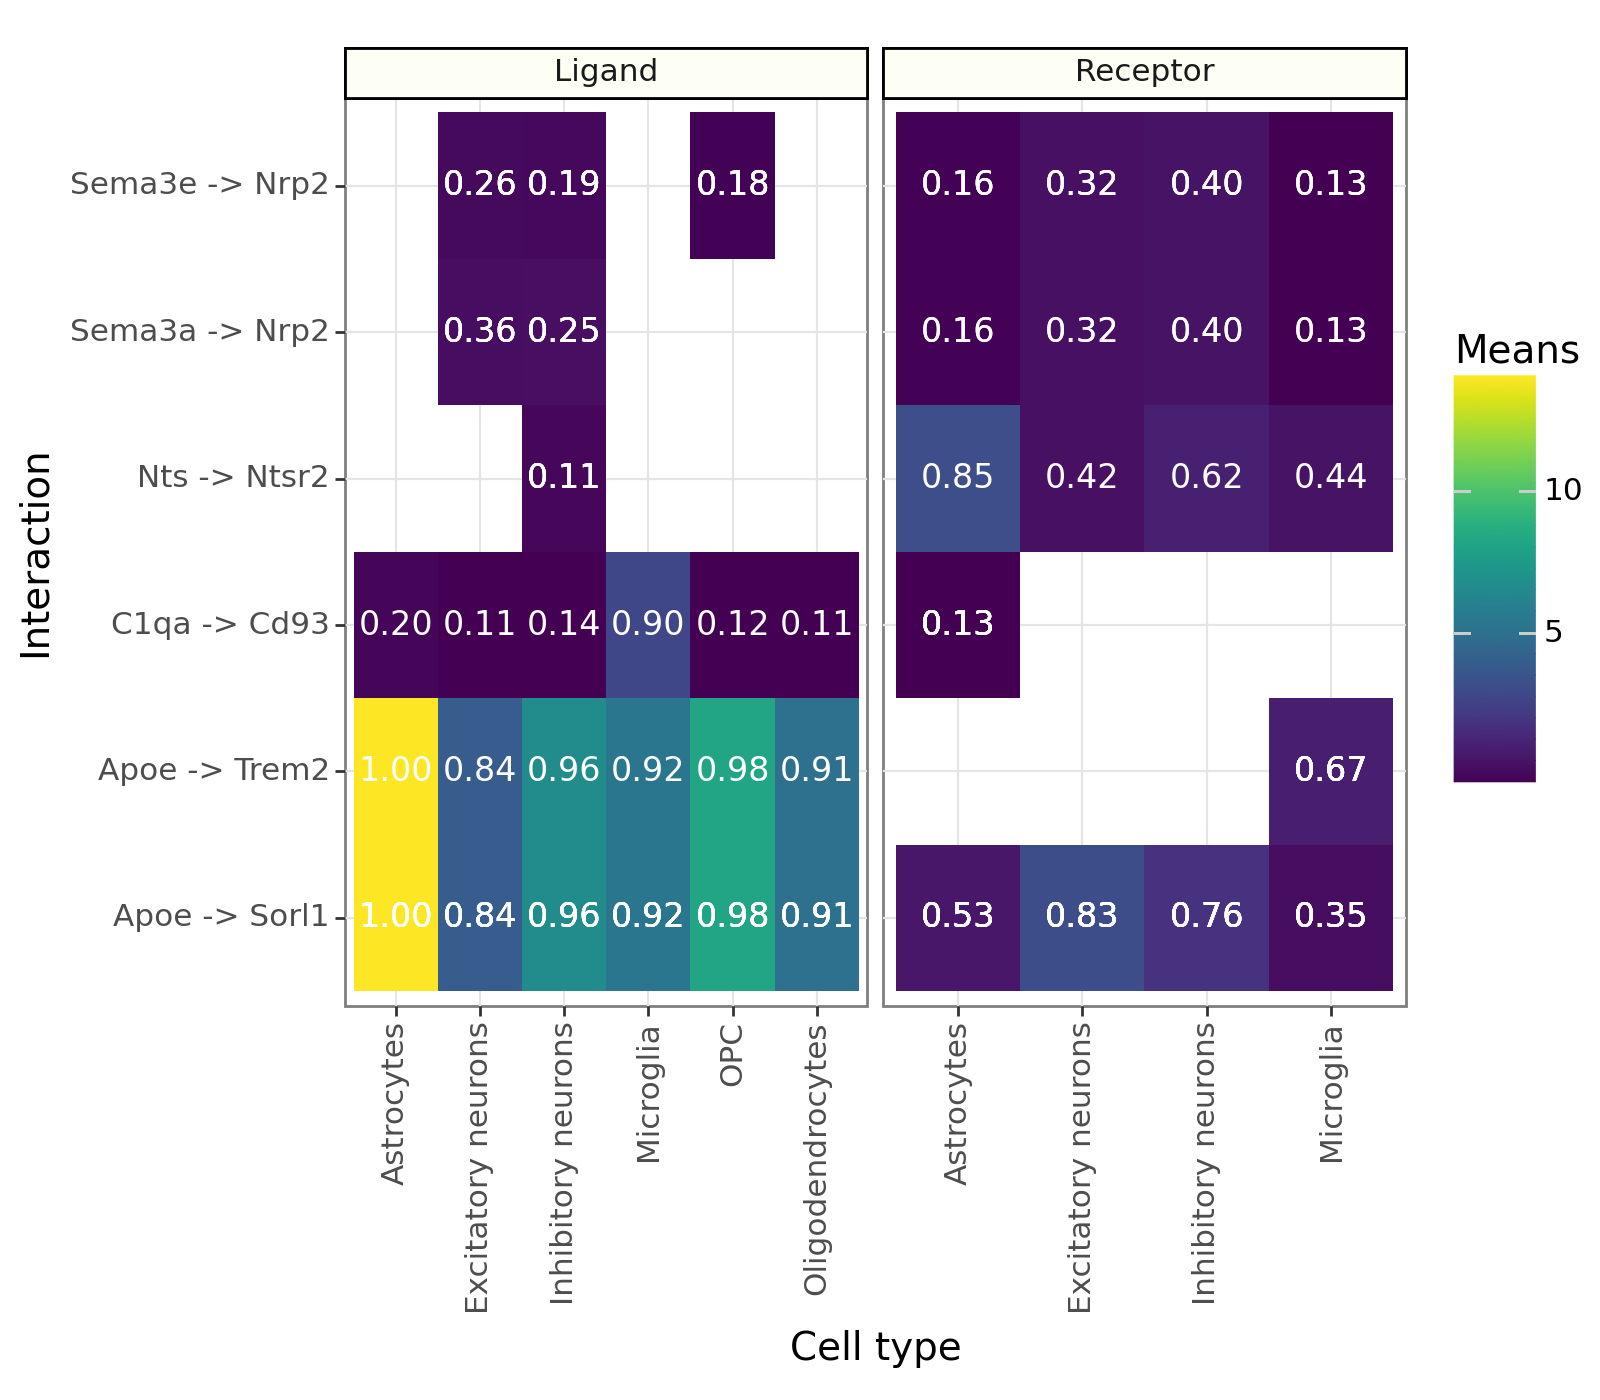

<Figure Size: (800 x 700)>

In [57]:
my_plot = li.pl.tileplot(adata = sub_adata,
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=20,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         target_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

TODO: Plot genes in space to see whether they are visually close.

<span style="color:red; font-weight:bold">Change the `expr_prop` in the CellPhoneDB function and try out some other tools like CellChat. How does it effect the results?.</span>

<span style="color:red; font-weight:bold">Compare the results for the healthy control or different time points. Do the CCC across cell types change?.</span>

## 2. SpatialDM: spatially-weighted analysis

In [ ]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import liana as li

from mudata import MuData

## 3. MISTY

MISTy is a framework that helps understand how different features, such as genes or cell types interact with each other in space. 
For this MISTy uses so called *views*, each describing a different spatial context.

<img src="./MISTy.png" alt="Alt Text" width="500"/>

In [74]:
import scanpy as sc
import decoupler as dc
import plotnine as p9
import liana as li

# Import Helper functions needed to create MISTy objects
from liana.method import MistyData, genericMistyData, lrMistyData

#Import predefined single view models
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

Before we run MISTy, let’s estimate pathway activities as a way to make the data a bit more interpretable. We will use [decoupler-py](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613) with pathways genesets from [PROGENy](https://www.nature.com/articles/s41467-017-02391-6). See [this](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) tutorial for details.

In [78]:
progeny = dc.get_progeny(organism='mouse', top=500)

In [79]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 350209 samples and 347 targets for 11 sources.


100%|██████████| 36/36 [00:05<00:00,  6.55it/s]


In [85]:
# extract progeny activities as an AnnData object
acts_progeny = li.ut.obsm_to_adata(adata, 'mlm_estimate')
acts_progeny

AnnData object with n_obs × n_vars = 350209 × 11
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'mlm_estimate', 'mlm_pvals'
    obsp: 'connectivities', 'distances'

In [86]:
acts_progeny.var_names

Index(['Androgen', 'Estrogen', 'JAK-STAT', 'MAPK', 'NFkB', 'PI3K', 'TGFb',
       'TNFa', 'VEGF', 'WNT', 'p53'],
      dtype='object')

In [ ]:
# Check how the pathway activities look like
sc.pl.spatial(acts_progeny, 
              color = ['Androgen', 'Estrogen', 'JAK-STAT', 'MAPK', 'NFkB', 'PI3K', 'TGFb', 'TNFa', 'VEGF', 'WNT', 'p53'], 
              cmap='RdBu_r',
              spot_size=10)

# References

[1] Dimitrov D., Schäfer P.S.L, Farr E., Rodriguez Mier P., Lobentanzer S., Badia-i-Mompel P., Dugourd A., Tanevski J., Ramirez Flores R.O. and Saez-Rodriguez J. LIANA+ provides an all-in-one framework for cell–cell communication inference. Nat Cell Biol (2024). https://doi.org/10.1038/s41556-024-01469-w

[2] Li, Z., Wang, T., Liu, P. & Huang, Y. SpatialDM for rapid identification of spatially co-expressed ligand–receptor and revealing cell–cell communication patterns. Nat Commun 14, 3995 (2023).
